## Resolution of a problem of irrigation water estimation using the shooting method in dimension 1

**But.** 

For given $A\in\mathbb{R}$, $G_2\in\mathbb{R}$, $C\in\mathbb{R}$, and $q_1,q_2>0$ considered ponderation weights, we want to construct the optimal pair
```math
\begin{aligned}
h^\star(t) &= -\tfrac{1}{q_2} G_2^\top p(t),\\
z(0) &= -\tfrac{1}{q_1} p(0)
\end{aligned}
```
where $(z,p)$ is solution of the optimality system  given by the TPBVP:
```math
\begin{aligned}
z'(t) &= A z(t) + G_2 h^\star(t) = A z(t) - \tfrac{1}{q_2} G_2 G_2^\top p(t), \quad z(0) = -\tfrac{1}{q_1} s,\\
p'(t) &= -A^\top p(t) - C^\top\!\big(C z(t) - y^{\mathrm m}(t)\big), \quad p(T)=0,
\end{aligned}
```
and $s := p(0)\in\mathbb{R}$ is **the shoot unknown**. 

---

### Implementation scheme (pseudo-code)
1. Give input data 
    - System: A, $G_2$, C
    - Objective: z0, h as known
    - Time discretization: T, N
    - Regulations: q1, q2
2. Forward z_true and y_m from known z0 and h
    - Integrate $z'(t) = A z(t) + G_2 h(t)$ using RK4 over grid t
    - Then compute $y(t) = C z(t)$
3. Backward p and $z_{est}$ from y_m with shooting method on p(0)
    - Define a function that integrate $(z'(t), p'(t))$ with $z(0) = -s/q1$, $p(T) = 0$ under the shoot $s=p(0)$.
    - Define the shooting function $F(s) := p(T; s)$ and find the good $s^\star$ such that $F(s^\star)=0$ by multiple integrations with $s$.
    - Integrate final (z, p) with the good $s^\star$.
4. Reconstruction of the irrigation $h_{est}$
    - $h(t) = -(1/q2) * G_2^T p(t)$
    - $z(0) = -(1/q1) * p(0)$
5. Make plots and metrics
    - Metrics: 
        - $Z0Error = z_0 - z_{0est}$
        - $RMSE_z = \sqrt{mean((z_{true} - z_{est})^2)}$
        - $RMSE_h = \sqrt{mean((z_{true} - z_{est})^2)}$
        - $Y Misfit = \int_0^T \|Cz(t)-y^m(t)\|^2 dt$
        - $H Energy = \int_0^T \|h(t)\|^2 dt$
    - Plots:
        - $z_{true}$ vs $z_{est}$
        - $h_{true}$ vs $h_{est}$
        - $z_{est}$ as function of q1 and/or q2
        - $h_{est}$ as function of q1 and/or q2
        - $RMSE_z$ as function of q1 and/or q2
        - $RMSE_h$ as function of q1 and/or q2
        - $Y Misfit$ as function of q1 and/or q2
        - $H Energy$ as function of q1 and/or q2

---

### Input example
- System: $A=2, G_2=3, C=4.9$
- Objective: $z_{0true}=4, h_{\mathrm{true}}(t)=t(1 - t)$
- Time discretization: $T=1, N=200$
- Regulation: $q_1=0.001, q_2=0.25$

---

### Ouput example (metrics)
z0 true = 4, z0 estimated = 4.000, error = 0.000<br>
RMSE(z) = 0.003<br>
RMSE(h) = 0.044<br>
Y Misfit = 0.000<br>
h Energy = 0.048

In [1]:
# Importations des modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Import steps 1-5 functions
from functions_n1 import *

In [3]:
# Step 1: Data input
# System parameters
n = 1
A = 2
G2 = 3
C = 4.9

# Objective
z0 = 4                      # supposed known
h = lambda t : t * (1 - t)  # supposed known


# Regulation parameters
q1 = 1
q2 = 1

# Time discretization
T = 1
N = 200
t  = np.linspace(0, T, N+1)

In [4]:
# Simulation for q1 and q2 (step 1 to 4)
h_true, z_true, y_m, z0_est, z_est, h_est = simulate_n1(A, G2, C, z0, h, T, N, q1, q2)

In [5]:
# showing true vs estimated
df = pd.DataFrame({"t": t, 'h_true': h_true, 'h_est': h_est[:, 0], 'z_true': z_true, 'z_est': z_est[:, 0], 'y_m': y_m})
display(df)

,t,h_true,h_est,z_true,z_est,y_m
0,0.000,0.000000,7.849720e+00,4.000000,2.616573,19.600000
1,0.005,0.004975,7.272981e+00,4.040238,2.760485,19.797167
2,0.010,0.009900,6.739348e+00,4.080955,2.897184,19.996681
3,0.015,0.014775,6.245620e+00,4.122155,3.027246,20.198562
4,0.020,0.019600,5.788832e+00,4.163843,3.151203,20.402830
...,...,...,...,...,...,...
196,0.980,0.019600,3.836584e-02,29.837870,29.814138,146.205564
197,0.985,0.014775,2.943515e-02,30.138005,30.112855,147.676224
198,0.990,0.009900,2.008312e-02,30.441083,30.414425,149.161306
199,0.995,0.004975,1.028152e-02,30.747133,30.718871,150.660952


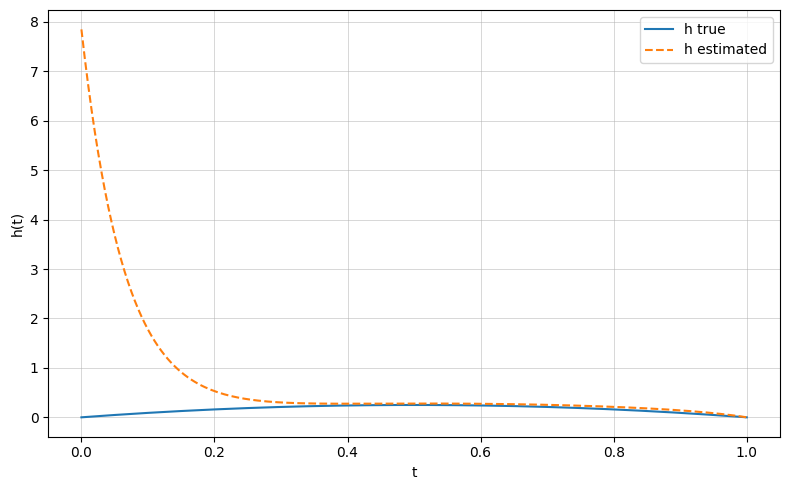

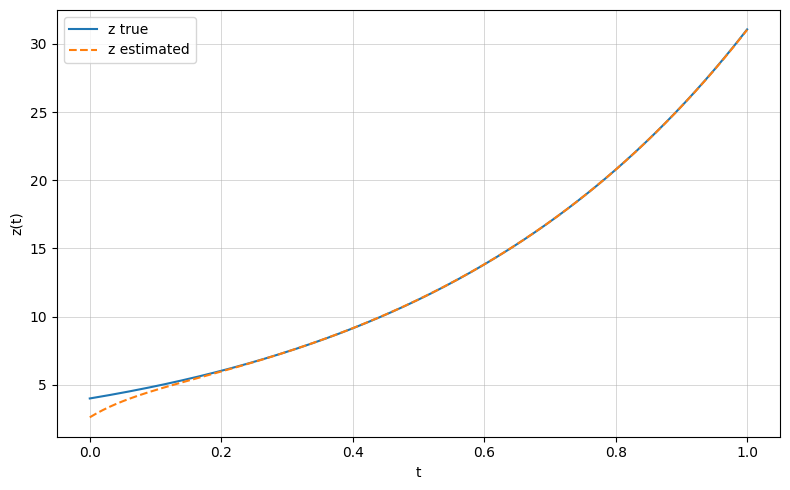

In [6]:
# Step 5: quick plots
make_plots(h_true, z_true, z_est, h_est, t, save=False, outdir = "figs")

In [7]:
# Step 5: metrics
z0_error, z0_energy, z_rmse, h_rmse, misfit, energy = compute_metrics(C, z0, h_true, z_true, y_m, z0_est, z_est, h_est, t)
print("===== Résultats =====")
print(f"z0 true = {z0}, z0 estimated = {z0_est:.3f}, error = {z0_error:.3f}")
print(f"RMSE(z) = {z_rmse:.3f}")
print(f"RMSE(h) = {h_rmse:.3f}")
print(f"Misfit = {misfit:.3f}")
print(f"Energy = {energy:.3f}")

===== Résultats =====
z0 true = 4, z0 estimated = 2.617, error = 1.383
RMSE(z) = 0.256
RMSE(h) = 1.467
Misfit = 1.466
Energy = 2.108


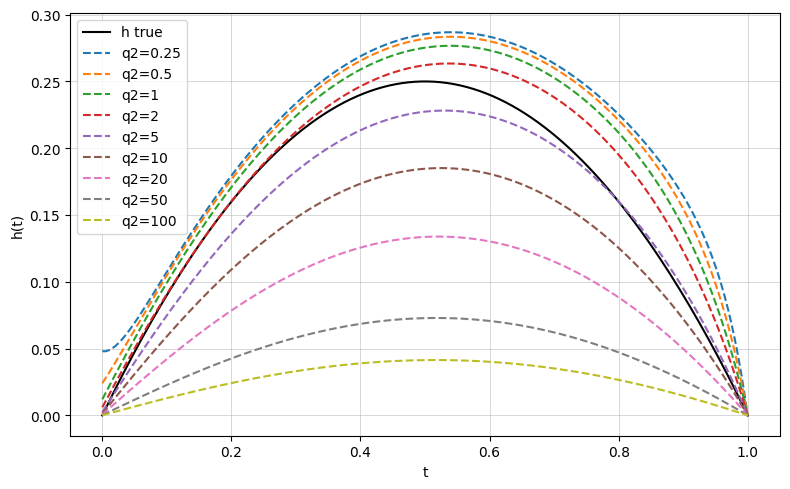

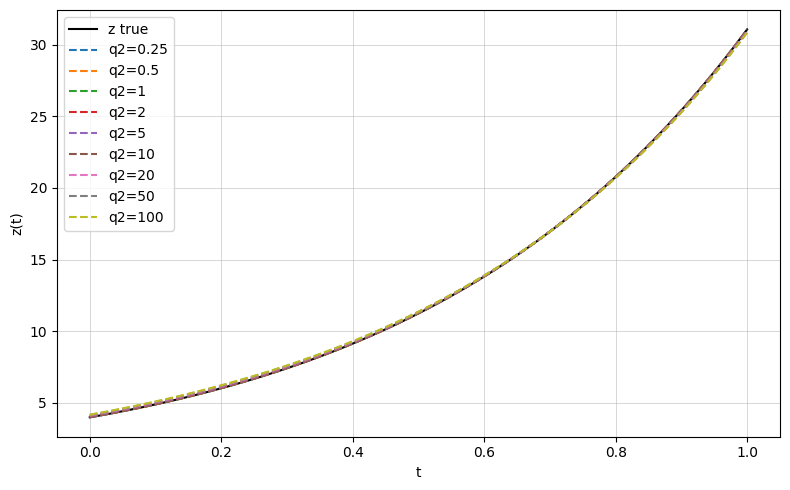

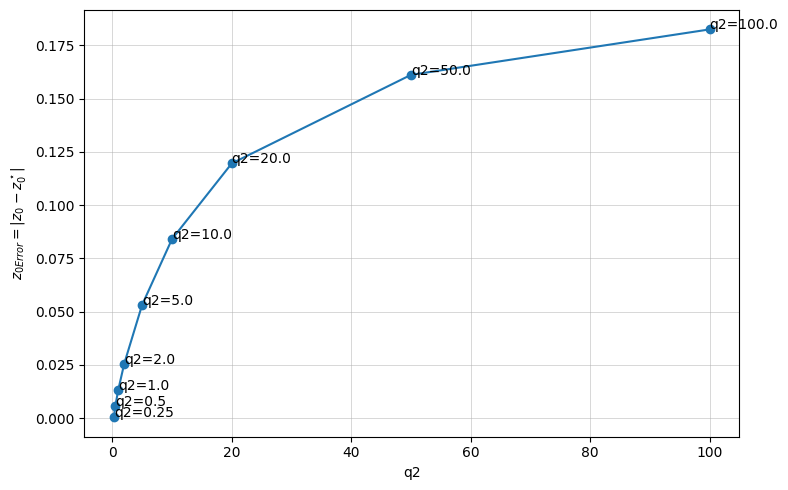

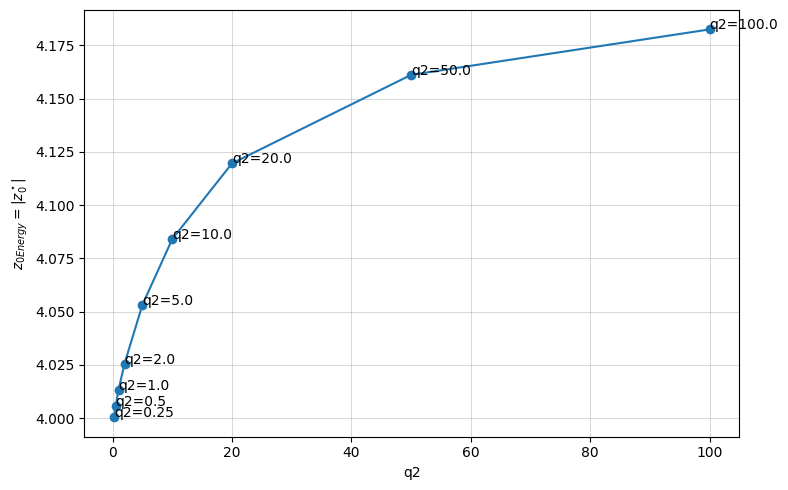

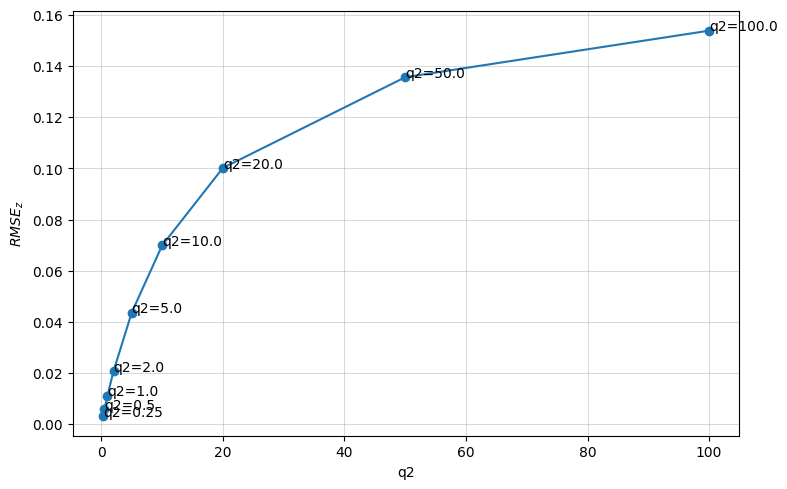

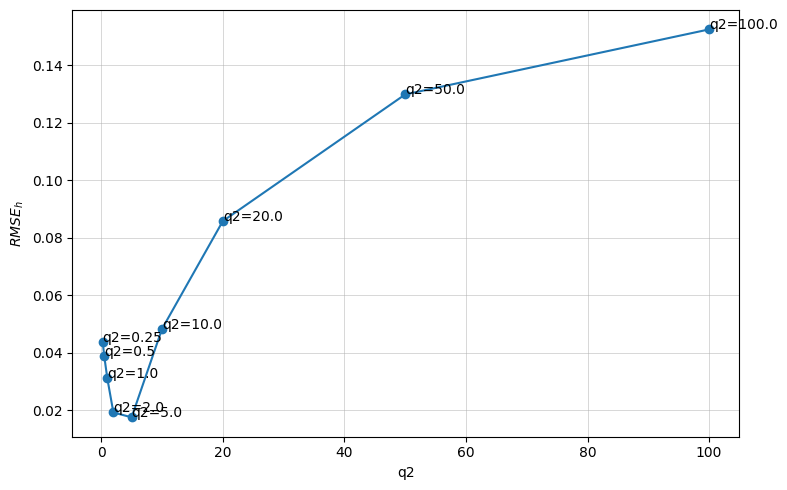

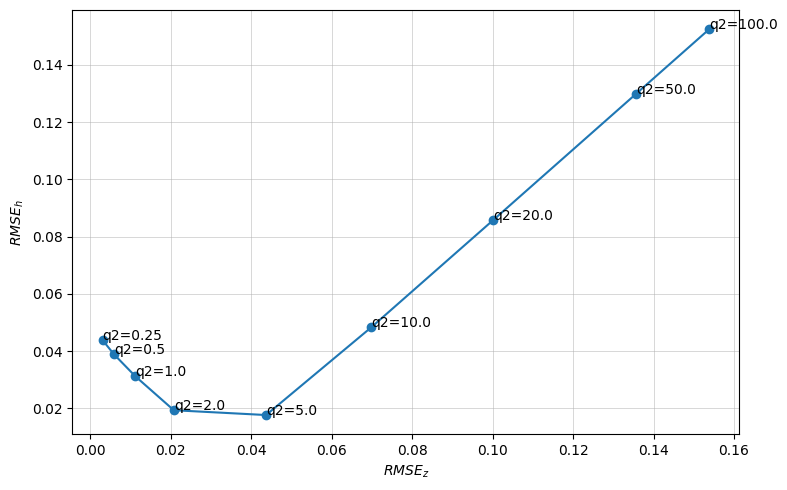

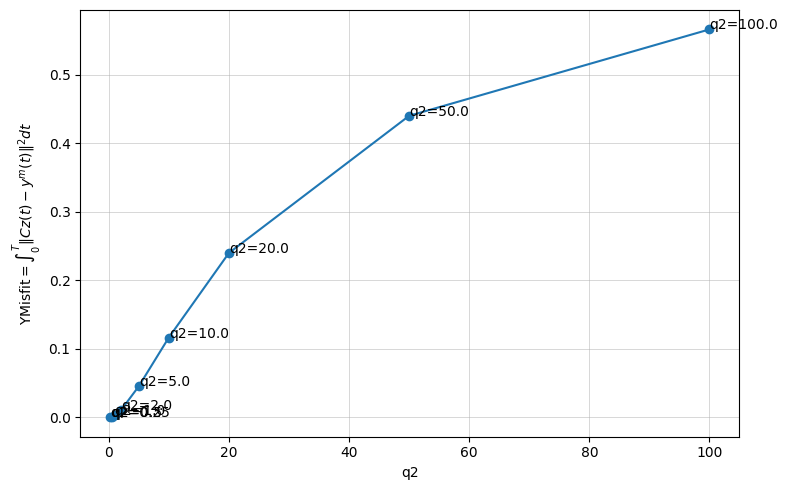

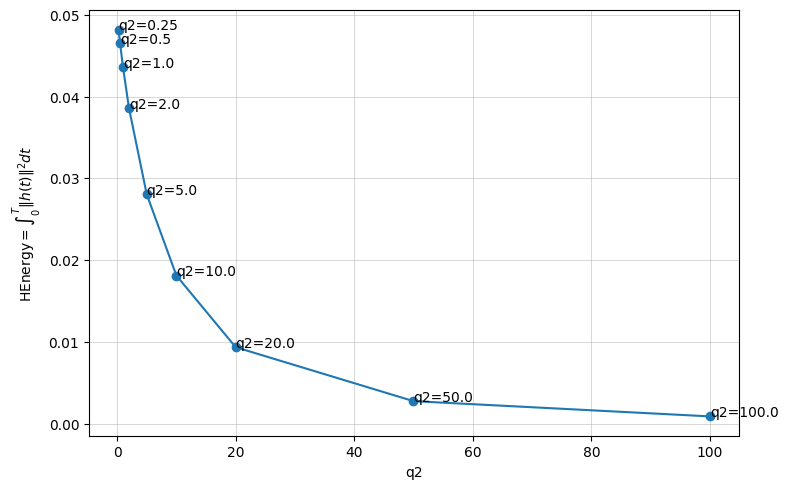

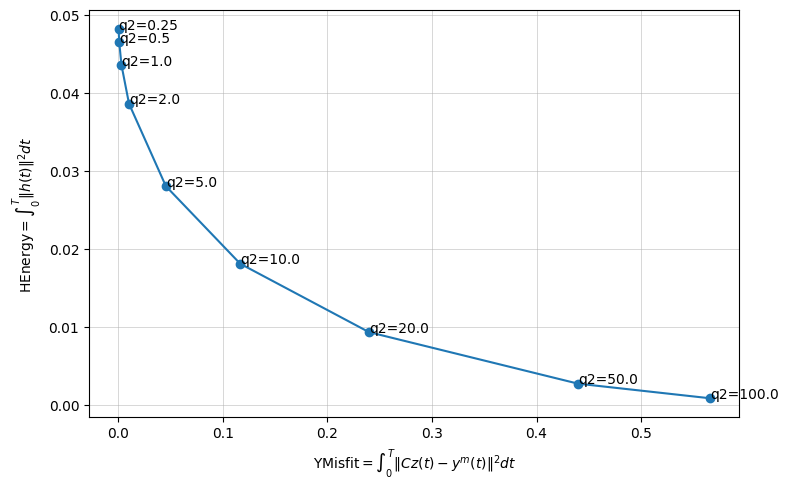

In [8]:
# Sensibility of q2: sweep q2, compute solutions & metrics
q1 = 0.001
q2_list = [0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]     # we start by 0.25 because q2<=0.1 flatten the curves

curves_z, curves_h, metrics = q2_sensibility(A, G2, C, z0, h, T, N, q1, q2_list, save=False, outdir = "figs")

The plots indicate to choice q2 between 0.25 -- 5

In [9]:
metrics

,q2,z0_error,z0_energy,z_rmse,h_rmse,misfit,energy
0,0.25,0.000342,4.000342,0.003051,0.043716,0.000215,0.048202
1,0.50,0.005519,4.005519,0.005844,0.038843,0.000799,0.046532
2,1.00,0.013214,4.013214,0.011142,0.031178,0.002931,0.043583
3,2.00,0.025529,4.025529,0.020717,0.019301,0.010190,0.038604
4,5.00,0.053178,4.053178,0.043663,0.017615,0.045449,0.028044
5,10.00,0.084041,4.084041,0.069865,0.048340,0.116561,0.018113
6,20.00,0.119567,4.119567,0.100161,0.085812,0.239786,0.009350
7,50.00,0.161143,4.161143,0.135613,0.129857,0.439824,0.002750
8,100.00,0.182494,4.182494,0.153803,0.152465,0.565844,0.000885


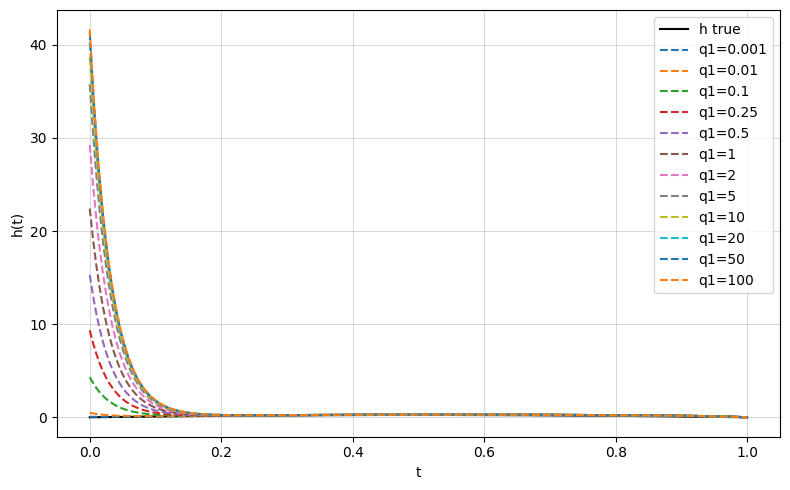

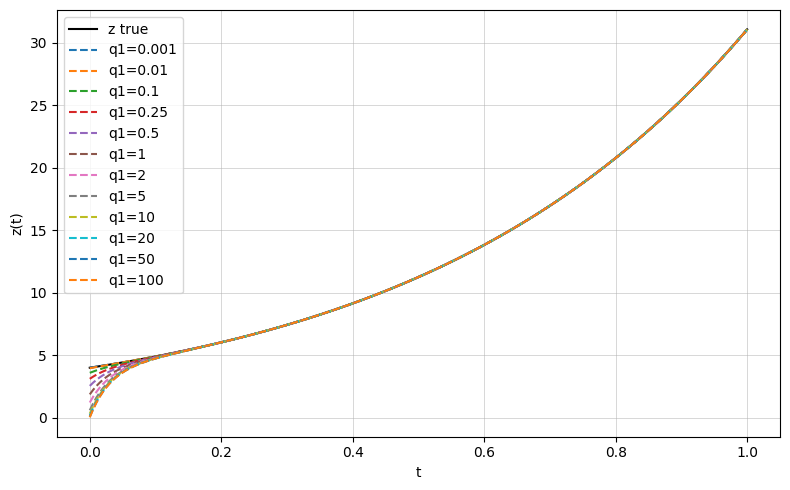

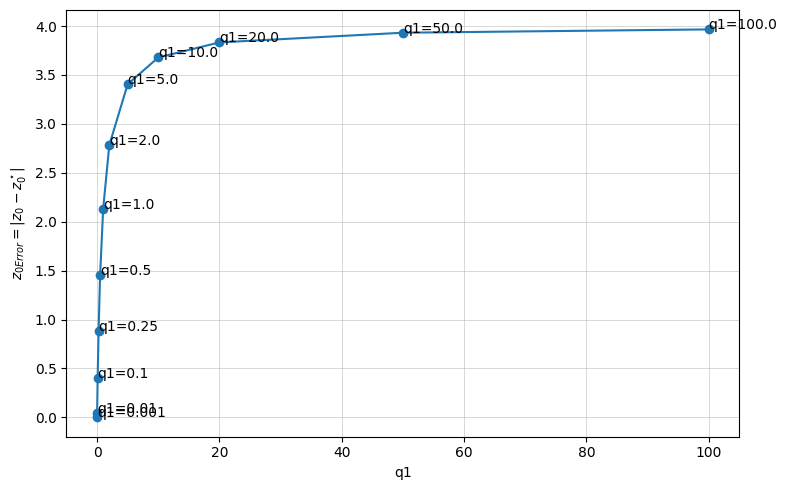

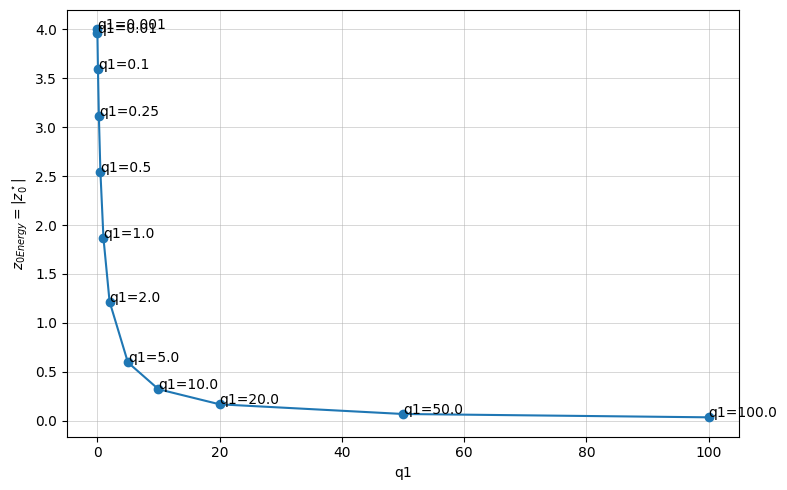

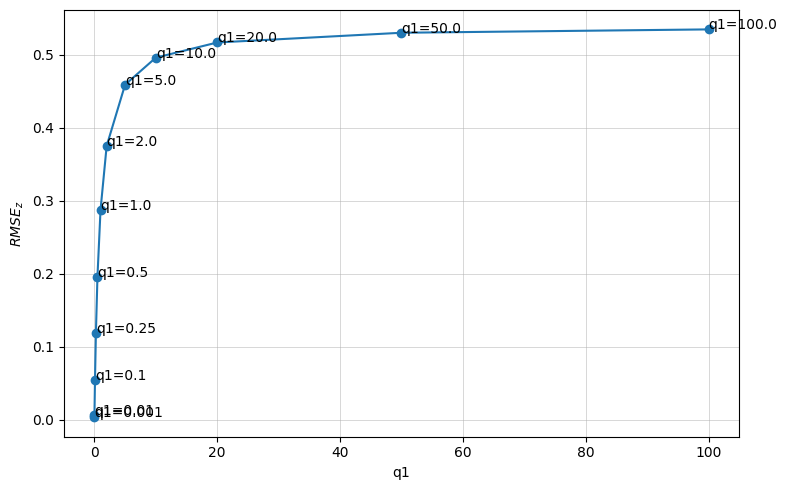

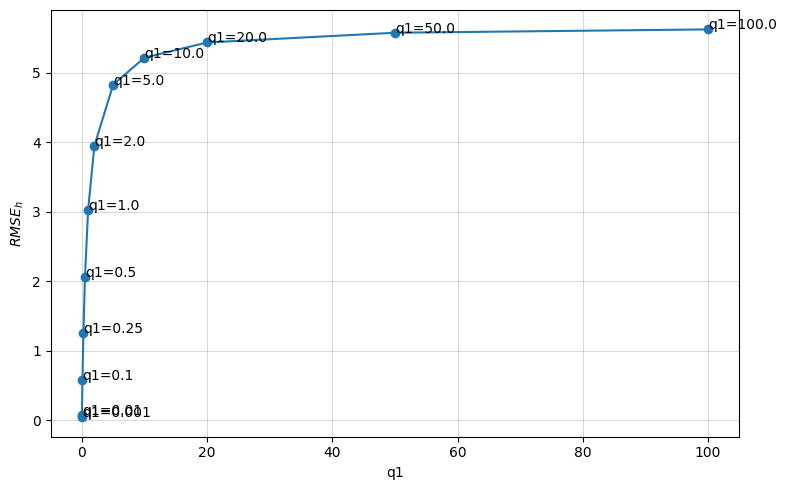

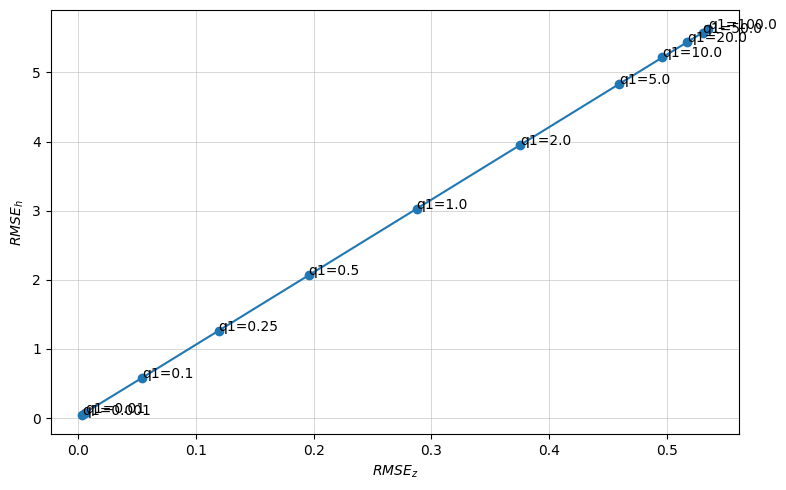

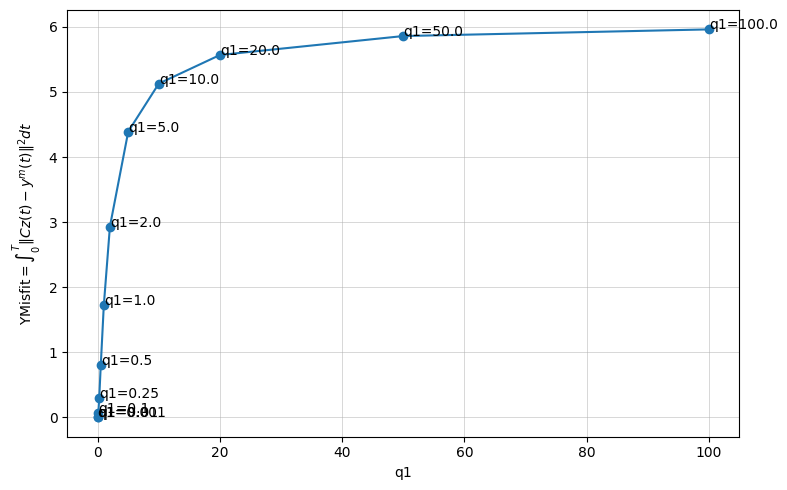

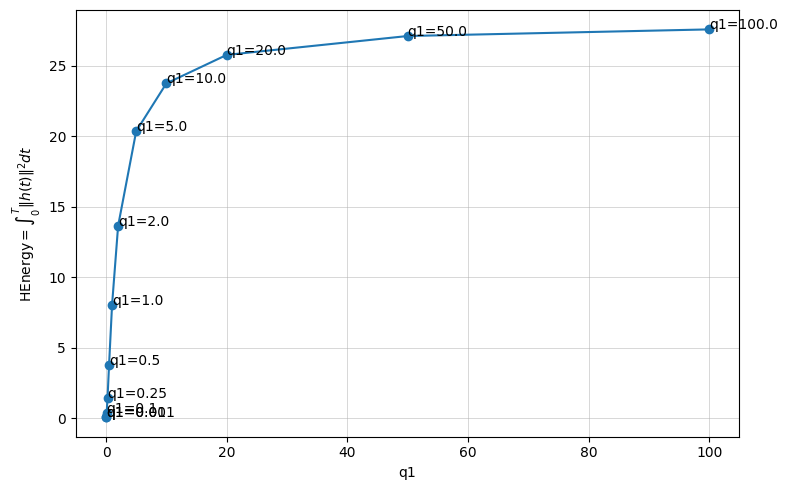

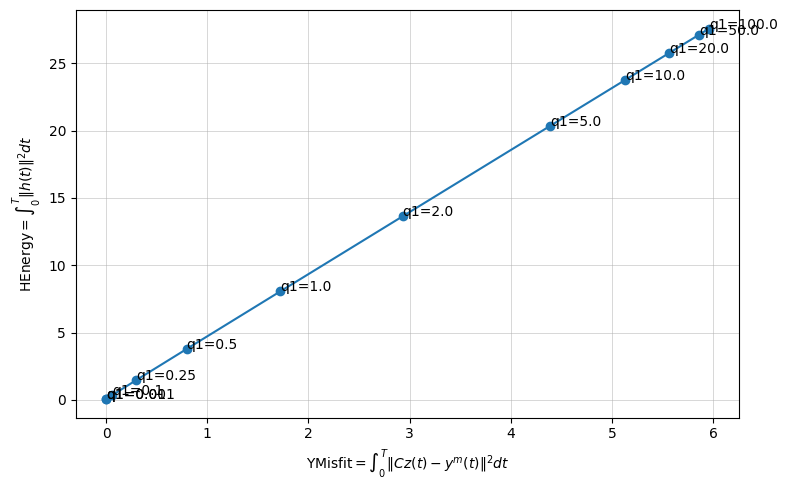

In [10]:
# Sensibility of q1: sweep q1, compute solutions & metrics
q1_list = [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]
q2 = 0.25

curves_z, curves_h, metrics = q1_sensibility(A, G2, C, z0, h, T, N, q1_list, q2, save=False, outdir = "figs")

We can consider q1 between 0.001 and 5

In [11]:
metrics

,q1,z0_error,z0_energy,z_rmse,h_rmse,misfit,energy
0,0.001,0.000342,4.000342,0.003051,0.043716,0.000215,0.048202
1,0.010,0.040380,3.959620,0.005868,0.078645,0.000723,0.052725
2,0.100,0.406218,3.593782,0.054506,0.585524,0.061774,0.352197
3,0.250,0.885768,3.114232,0.119203,1.263758,0.295769,1.450241
4,0.500,1.452359,2.547641,0.195679,2.065823,0.797324,3.779153
5,1.000,2.132053,1.867947,0.287433,3.028189,1.720703,8.047111
6,2.000,2.781975,1.218025,0.375171,3.948467,2.931810,13.631982
7,5.000,3.404039,0.595961,0.459149,4.829325,4.391497,20.354483
8,10.000,3.678067,0.321933,0.496143,5.217359,5.127760,23.743162
9,20.000,3.832293,0.167707,0.516964,5.435750,5.567223,25.765287


Optimal compromise :
  q1* = 0.001, q2* = 0.25
  z0 error = 0.000
  RMSE(z) = 0.003
  RMSE(h) = 0.044
  YMisfit*   = 0.000
  HEnergy*   = 0.048
  Objective = 0.016
---------------------------------------------------------------------- 
Plot process: ...


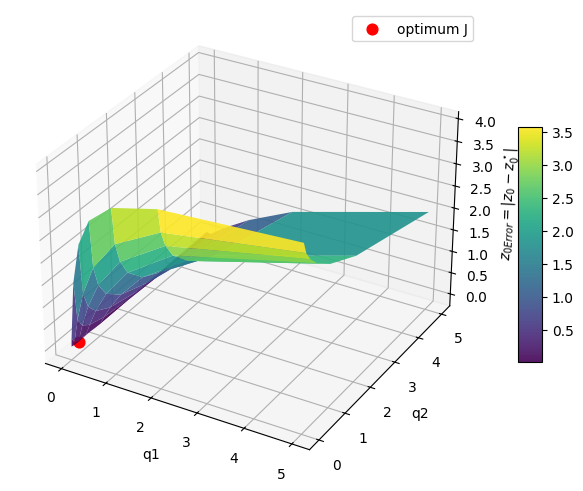

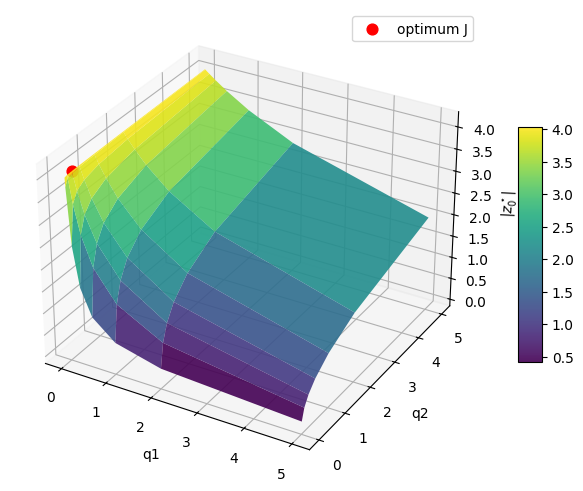

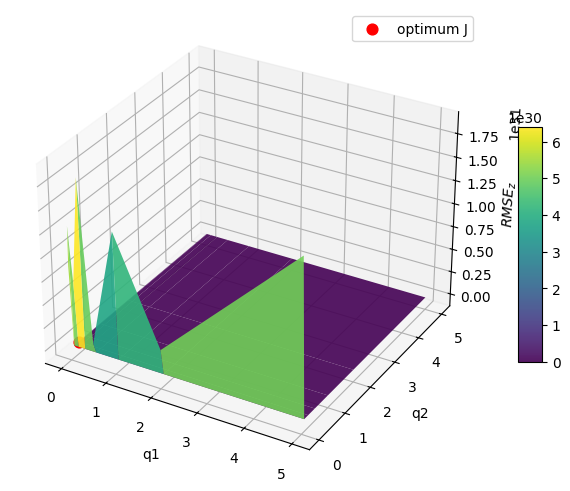

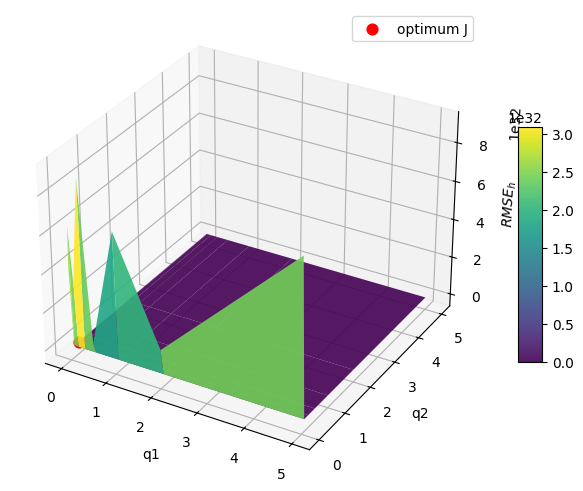

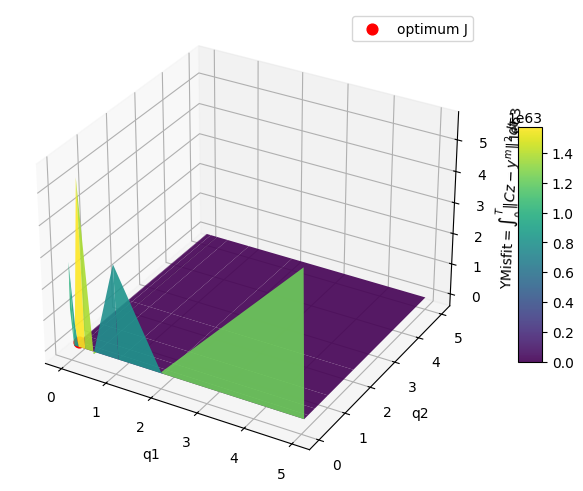

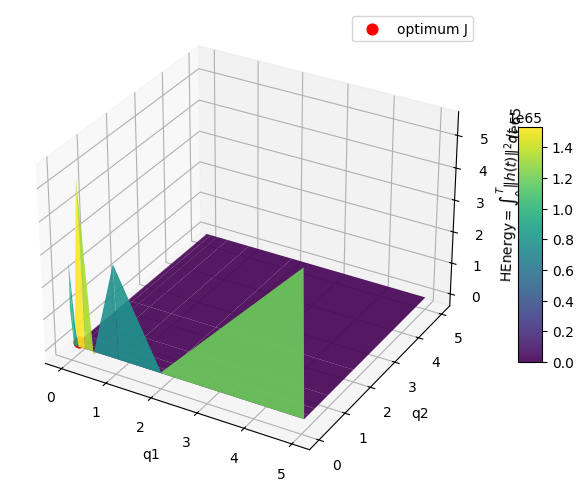

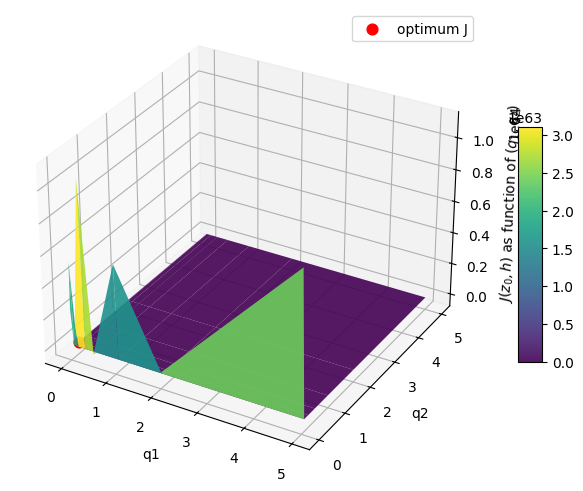

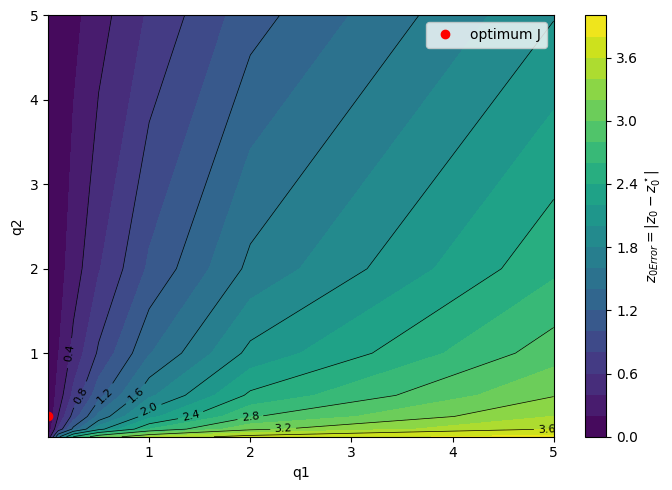

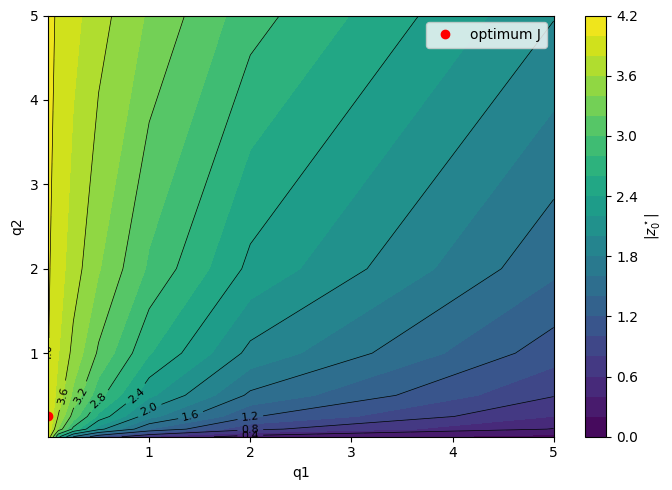

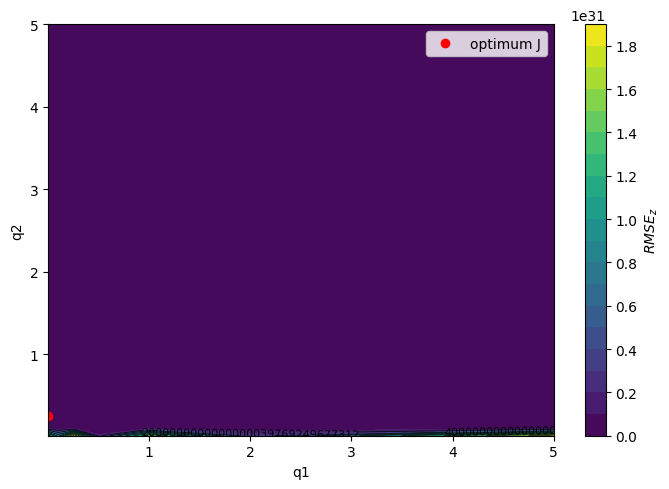

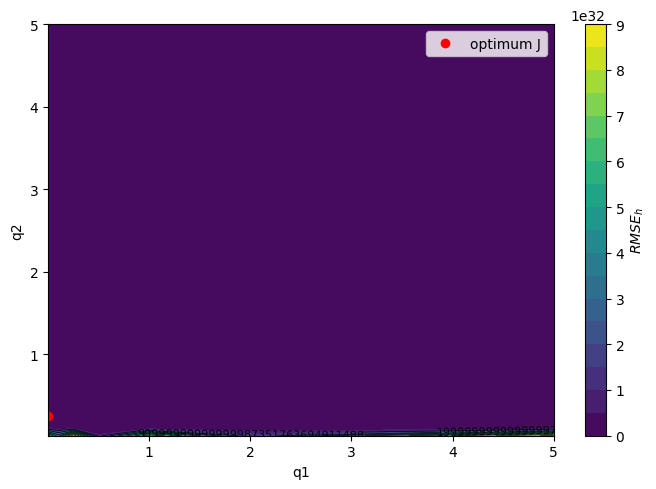

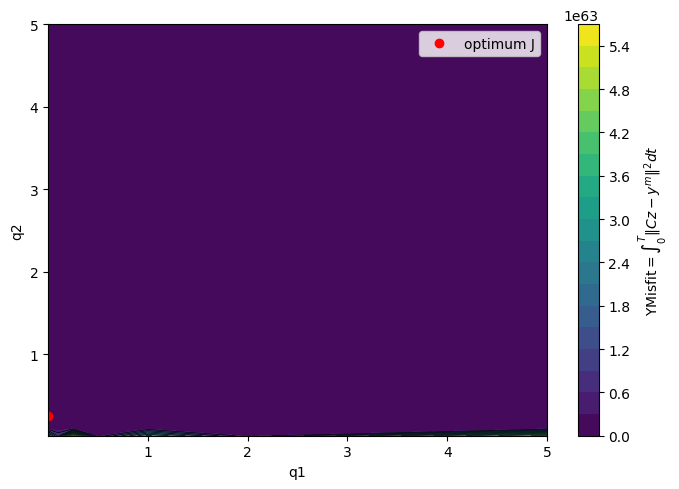

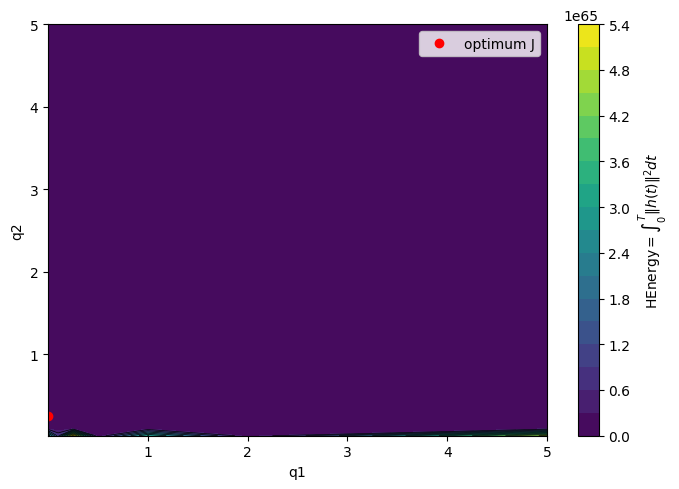

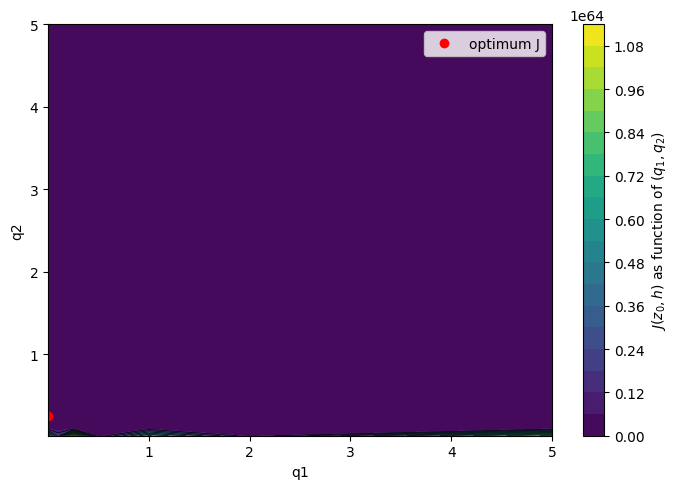

In [12]:
# Sensibility of q1 and q2: sweep q1 and q2, compute solutions & metrics, and search optimum q1 and q2
# q1_vals = [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]
# q2_vals = [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100]

# q1_vals = np.linspace(0.001, 1, 10)
# q2_vals = np.linspace(0.001, 1, 10)

q1_vals = [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 5]
q2_vals = [0.01, 0.1, 0.25, 0.5, 1, 2, 5]

curves_z, curves_h, metrics, q1_opt, q2_opt = q12_sensibility_with_optimum(A, G2, C, z0, h, T=1, N=200, 
                                                                           q1_list=q1_vals, q2_list=q2_vals, save=False, outdir="figs")

In [13]:
metrics

,q1,q2,z0_error,z0_energy,z_rmse,h_rmse,misfit,energy,objective
0,0.001,0.01,0.023553,3.976447,8.841423e+30,4.273755e+32,1.256417e+63,1.222691e+65,2.479108e+63
1,0.001,0.10,0.005027,3.994973,3.335038e+01,4.950374e+02,2.225121e+04,2.041969e+05,4.267090e+04
2,0.001,0.25,0.000342,4.000342,3.051499e-03,4.371553e-02,2.145336e-04,4.820169e-02,1.626530e-02
3,0.001,0.50,0.005519,4.005519,5.844187e-03,3.884349e-02,7.993460e-04,4.653221e-02,2.807097e-02
4,0.001,1.00,0.013214,4.013214,1.114232e-02,3.117823e-02,2.931381e-03,4.358280e-02,5.052739e-02
5,0.001,2.00,0.025529,4.025529,2.071705e-02,1.930058e-02,1.018983e-02,3.860392e-02,9.142320e-02
6,0.001,5.00,0.053178,4.053178,4.366256e-02,1.761481e-02,4.544940e-02,2.804400e-02,1.897226e-01
7,0.010,0.01,0.227391,3.772609,1.310241e+31,6.333425e+32,2.759255e+63,2.685188e+65,5.444443e+63
8,0.010,0.10,0.070494,3.929506,4.837106e+00,7.181983e+01,4.680812e+02,4.298741e+03,8.979946e+02
9,0.010,0.25,0.040380,3.959620,5.867550e-03,7.864484e-02,7.227671e-04,5.272502e-02,5.350022e-02


===== Results =====
z0 true = 4, z0 estimated = 4.000, error = 0.000
RMSE(z) = 0.003
RMSE(h) = 0.044
Misfit = 0.000
Energy = 0.048


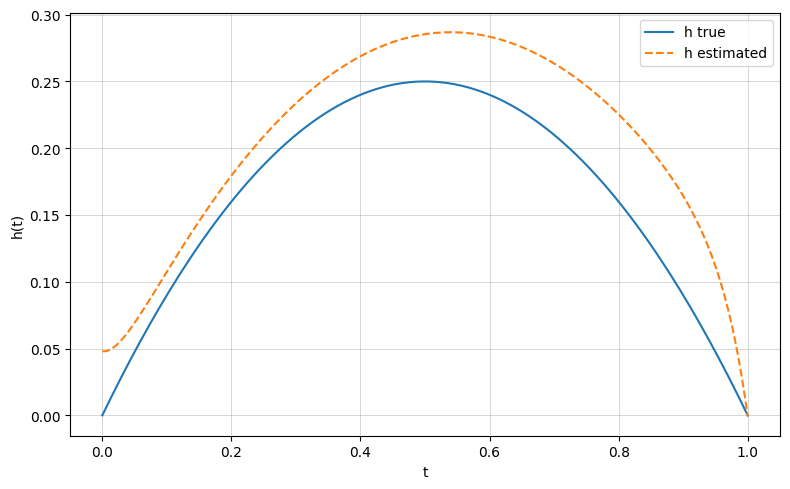

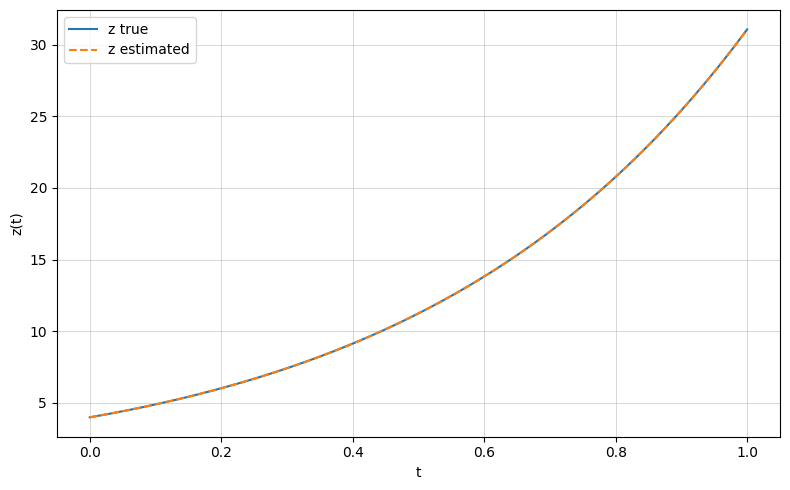

In [14]:
# Simulation for q1_opt and q2_opt (step 1 to 4)
h_true, z_true, y_m, z0_est, z_est, h_est = simulate_n1(A, G2, C, z0, h, T, N, q1_opt, q2_opt)

# Step 5: metrics
z0_error, z0_energy, z_rmse, h_rmse, misfit, energy = compute_metrics(C, z0, h_true, z_true, y_m, z0_est, z_est, h_est, t)
print("===== Results =====")
print(f"z0 true = {z0}, z0 estimated = {z0_est:.3f}, error = {z0_error:.3f}")
print(f"RMSE(z) = {z_rmse:.3f}")
print(f"RMSE(h) = {h_rmse:.3f}")
print(f"Misfit = {misfit:.3f}")
print(f"Energy = {energy:.3f}")

# Step 5: quick plots
make_plots(h_true, z_true, z_est, h_est, t, save=False, outdir = "figs")